# Assignment 1 - Text Preprocessing and Bag Of Words
### Submitted by : Shivani Shrikant Naik
#### Reference: Text Classfication Python Notebook

* All reviews from the movie_reviews dataset have already been converted to lowercase in nltk, so I have displayed lowercasing custom function working on a test dataframe
* Use of regular expression for punctuation removal
* Used lemmatization for final modeling
* Used external stopwords.txt for stopword removal
* Used nltk sentiment analyser with Vader

In [263]:
# Import necessary libraries
import nltk
import pandas as pd
import numpy as np
from pprint import pprint
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import scikitplot as skplt
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from nltk.sentiment import SentimentIntensityAnalyzer

from nltk.tokenize import word_tokenize
from nltk.sentiment.util import *
from nltk.classify import NaiveBayesClassifier

%matplotlib inline

In [ ]:
# Download IMDB movie reviews dataset from NLTK
nltk.download("movie_reviews")
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')


In [3]:
# Import movie reviews
from nltk.corpus import movie_reviews

###  [EXTRA] lowercasing with Entity Recognition mentioned in class - using Part of Speech Tagging


In [4]:
test_df = pd.DataFrame({'text':["Men, plan's, an astonishing canal - Panama. ", 
                                "They refuse to permit US to obtain the licence",
                               "She Likes India"]})
def tokens(df, col, tokenized_col):
        df[tokenized_col] = df[col].apply(lambda x:x.split())
        
def punctuation(df, col, regex = False):
        df[col] = df[col].apply(lambda x: re.sub(pattern = '\\n|\\t|[^\w\s]', repl = "", string = x))


def toLowerWithPartOfSpeech(df, col):
    # Remove punctuation to avoid tagging normal noun as proper noun
    punctuation(df,col)
    # Tokenize the sentence to perform part of speech tagging
    tokens(df,col,"pos_tokens")
    
    # Perform part of speech tagging to identify entities and proper nouns
    df["pos_tags"] = df["pos_tokens"].apply(nltk.pos_tag) 
    # Filter proper nouns (NNP)
    df["nnp_pos"] = df["pos_tags"].apply(lambda x: [tag[0] for tag in x if tag[1]=="NNP"])
    # Create list of all proper nouns
    pos_list = list(np.concatenate(df['nnp_pos']))
    
    # lowercase tokens if they are not entities / proper nouns like USA, US, Panama etc
    df["lowered"] = df["pos_tokens"].apply(lambda x: " ".join(word.lower() if word not in pos_list else word for word in x ))

toLowerWithPartOfSpeech(test_df,"text")
test_df[["text", "lowered"]]


,text,lowered
0,Men plans an astonishing canal Panama,men plans an astonishing canal Panama
1,They refuse to permit US to obtain the licence,they refuse to permit US to obtain the licence
2,She Likes India,she likes India


# Class encapsulating all functions

In [264]:
# Class containing text processing and modeling functions
class TextProcess():
    def __init__(self):
        # Initialise dataset while instantiating
        self.make_dataset()
    
    # Create combined dataset with positive and negative reviews
    def make_dataset(self):
        self.neg_fileids = movie_reviews.fileids('neg')
        self.pos_fileids = movie_reviews.fileids('pos')
        neg_data = pd.DataFrame(
            {'review':movie_reviews.raw(fileids=[f]),'label': 'neg'} for f in self.neg_fileids
        )
        pos_data = pd.DataFrame(
            {'review':movie_reviews.raw(fileids=[f]),'label': 'pos'} for f in self.pos_fileids
        )
        self.df = pd.concat([pos_data, neg_data]).reset_index(drop=True)
        self.df["raw_review"] = self.df["review"]
    
    # Exploratory data analysis function
    def eda(self):
        print("Total number of movies: ", len(movie_reviews.fileids()))
        print("Movie review categories: ", movie_reviews.categories())
        print("Number of positive and negative reviews:\n", self.df['label'].value_counts())
        print("\n\n")
        print("Sample review: ",  self.df['review'][2])
    
    # Lowercase conversion for specified column of dataframe   
    def toLower(self, col):
        self.df[col] = self.df[col].apply(lambda x:x.lower())
    
    
    def toLowerWithPartOfSpeech(self, col, pos_entity_lower = True):
        if pos_entity_lower == True:
            # Remove punctuation to avoid tagging normal noun as proper noun
            punctuation(self.df,col)
            # Tokenize the sentence to perform part of speech tagging
            tokens(self.df,col,"pos_tokens")

            # Perform part of speech tagging to identify entities and proper nouns
            self.df["pos_tags"] = self.df["pos_tokens"].apply(nltk.pos_tag) 
            # Filter proper nouns (NNP)
            self.df["nnp_pos"] = self.df["pos_tags"].apply(lambda x: [tag[0] for tag in x if tag[1]=="NNP"])
            # Create list of all proper nouns
            pos_list = list(np.concatenate(self.df['nnp_pos']))

            # lowercase tokens if they are not entities /proper nouns like USA, US, Panama etc
            self.df[col] = self.df["pos_tokens"].apply(lambda x: " ".join(word.lower() if word not in pos_list else word for word in x ))
        else:
            self.df[col] = self.df[col].apply(lambda x:x.lower())

    
    # Remove punctuations from column using regular expression
    def removePunctuation(self, col):
        self.df[col] = self.df[col].apply(lambda x: re.sub(pattern = '[^\w\s]', repl = "", string = x))
        self.df[col] = self.df[col].apply(lambda x: re.sub(pattern = '\\n|\\t', repl = " ", string = x))

        
    
    # Remove stopwords using externally downloaded stopwords.txt file 
    def removeStopwords(self,col):
        stopwords = pd.read_csv("stopwords.txt",header=None)
        stopwords = list(stopwords[0])
        self.df[col] = self.df[col].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords)) 
        
    # Tokenize string using space
    def tokenize(self, col):
        self.df[col+'_tokenized'] = self.df[col].apply(lambda x:x.split())
    
    # Perform stemming
    def nltk_stem(self, col):
        stemmer = PorterStemmer()
        self.df[col] = self.df[col].apply(lambda x: [stemmer.stem(word) for word in x])
    
    # Perform lemmatization
    def wordnet_lemmatize(self, col):
        lemmatizer = WordNetLemmatizer()
        self.df[col] = self.df[col].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    
    # Plot frequencies of words
    def freq_plot(self, col):
        self.word_frequency = pd.Series(np.concatenate(self.df[col])).value_counts()
        freq_words = self.word_frequency[:15]
        plt.figure(figsize = (15,8))
        plt.title("Top 15 word frequencies")
        sns.barplot(x = freq_words, y = freq_words.index, orient = 'h')
        plt.figure(figsize = (15,8))

        sorted_freq = sorted(list(self.word_frequency), reverse=True)
        plt.title("Log Frequencies")

        plt.loglog(sorted_freq)
        
        plt.figure(figsize = (15,8))
        plt.title("Histogram of log frequencies")
        plt.hist(sorted_freq, bins=50, log=True)
        
         
    # Remove 'n' frequent unimportant words, n can be a parameter that can be changed
    def remove_freq_unimportant_words(self, col, n = 3):
        freq_unimp_words = pd.Series(np.concatenate(self.df[col])).value_counts()[:n].index.tolist() #check how to decide
        self.df[col] = self.df[col].apply(lambda x:[word for word in x if word not in freq_unimp_words])
    
    # Create bag of words 
    def create_bow(self,  col, max_features = 30000):
        self.df['review_cleaned'] = self.df[col].apply(lambda x: ' '.join(x))
        X = self.df['review_cleaned']
        y = self.df['label']
    
        le = LabelEncoder()
        y = le.fit_transform(y)
        cnt_vec = CountVectorizer(analyzer="word", max_features = max_features) #try tuning
        bow = cnt_vec.fit_transform(X)
    
        return(cnt_vec, bow, y)
    
    # Assigning sentiment label to one review using NLTK sentiment analyzer
    def sentiment_label(self, text):
        sia = SentimentIntensityAnalyzer()
        # predict polarity score for every sentence and take average of scores
        sentences = nltk.sent_tokenize(text)
        
        scores = [ sia.polarity_scores(sentence)["compound"] for sentence in sentences]
        if np.mean(scores) > 0.1:
            return "pos"
        else:
            return "neg"
    
    # NLTK Sentiment Analyzer
    def nltk_sentiment_analysis(self, col):
        self.df["nltk_sentiment"] = self.df[col].apply(lambda x: self.sentiment_label(x))
    
    # NLTK Sentiment analysis model evaluation
    def nltk_sentiment_evaluation(self):
        acc = accuracy_score(self.df.nltk_sentiment, self.df.label)
        class_report = classification_report(self.df.label, self.df.nltk_sentiment)
        
        print ("Accuracy for NLTK Sentiment Analyzer:: ", acc)
        print ("Classification report :: \n", class_report)
    
    # NLTK Sentiment Analyzer approach 2
    def nltk_sentiment_analysis_bow_2(self, model):
        negative_fileids = movie_reviews.fileids('neg')
        positive_fileids = movie_reviews.fileids('pos')
        
        # make tokenized movie reviews data
        positive_reviews = [(word_tokenize(movie_reviews.raw(fileids=[f])), 'pos') for f in positive_fileids]
        negative_reviews = [(word_tokenize(movie_reviews.raw(fileids=[f])), 'neg') for f in negative_fileids]

        # 80% train test split
        train_pos_reviews = positive_reviews[:800]
        test_pos_reviews = positive_reviews[800:]
        train_neg_reviews = negative_reviews[:800]
        test_neg_reviews = negative_reviews[800:]
        training_reviews = train_pos_reviews+train_neg_reviews
        testing_reviews = test_pos_reviews+test_neg_reviews

        words = sentim_analyzer.all_words([mark_negation(doc) for doc in training_reviews])

        sentim_analyzer.all_words([review for review in training_reviews])

        unigram_feats = sentim_analyzer.unigram_word_feats(words, min_freq=4)

        # Add a feature extractor
        sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)

        # Generate bag of words training and testing features
        training_set = sentim_analyzer.apply_features(training_reviews)
        test_set = sentim_analyzer.apply_features(testing_reviews)


        trainer = model
        classifier = sentim_analyzer.train(trainer, training_set)

        # Evaluate model
        for key,value in sorted(sentim_analyzer.evaluate(test_set).items()):
            print('{0}: {1}'.format(key, value))
            
            
    # Train and evaluate specified model, function can be reused with different models
    def train_evaluate_model(self, model, X_train, X_test, y_train, y_test):
        model.fit(X_train, y_train)
        pred_test  = model.predict(X_test)
        pred_train = model.predict(X_train)
        prob_test  = model.predict_proba(X_test)
        prob_train = model.predict_proba(X_train)
        train_acc = accuracy_score(y_train, pred_train)
        test_acc  = accuracy_score(y_test, pred_test)
        train_auc_score = roc_auc_score(y_train, prob_train[:,1])
        test_auc_score = roc_auc_score(y_test, prob_test[:,1])
        class_report = classification_report(y_test, pred_test)

        print ("Model ROC-AUC score for training sample: %.3f" \
                                      % train_auc_score)
        print ("Model ROC-AUC score for test sample: %.3f" \
                                      % test_auc_score)
        print ("Train Accuracy: ", train_acc)
        print ("Test Accuracy: ", test_acc)
        print ("Classification report: \n", class_report)
        skplt.metrics.plot_confusion_matrix(y_test, pred_test, title="Confusion Matrix",
                text_fontsize='large')
        plt.show()
        return(model)
    
    def hyperparameter_tuning(self, model, param_grid, X_train, y_train, cv = 5):
        
        optimal_model = GridSearchCV(
            estimator = model,
            param_grid=param_grid,
            n_jobs = -1,
            cv = cv,
            scoring = 'accuracy',
            verbose=2
        )
        optimal_model.fit(X_train, y_train)
        print(optimal_model.best_score_)
        print(optimal_model.best_params_)
        return(optimal_model.best_estimator_)
        


## EDA

Exploratory data analysis shows the dataset has 2000 movie reviews, equally distributed between positive and negative reviews. There is no class imbalance, so we can use accuracy metric for evaluation.

word cloud

In [265]:
text_process = TextProcess()
text_process.eda()

Total number of movies:  2000
Movie review categories:  ['neg', 'pos']
Number of positive and negative reviews:
 pos    1000
neg    1000
Name: label, dtype: int64



Sample review:  you've got mail works alot better than it deserves to . 
in order to make the film a success , all they had to do was cast two extremely popular and attractive stars , have them share the screen for about two hours and then collect the profits . 
no real acting was involved and there is not an original or inventive bone in it's body ( it's basically a complete re-shoot of the shop around the corner , only adding a few modern twists ) . 
essentially , it goes against and defies all concepts of good contemporary filmmaking . 
it's overly sentimental and at times terribly mushy , not to mention very manipulative . 
but oh , how enjoyable that manipulation is . 
but there must be something other than the casting and manipulation that makes the movie work as well as it does , because i absolutely hated the previ

In [255]:
text_process.df['review']

0       films adapted from comic books have had plenty...
1       every now and then a movie comes along from a ...
2       you've got mail works alot better than it dese...
3        " jaws " is a rare film that grabs your atten...
4       moviemaking is a lot like being the general ma...
                              ...                        
1995    if anything , " stigmata " should be taken as ...
1996    john boorman's " zardoz " is a goofy cinematic...
1997    the kids in the hall are an acquired taste . \...
1998    there was a time when john carpenter was a gre...
1999    two party guys bob their heads to haddaway's d...
Name: review, Length: 2000, dtype: object

In [256]:
review_num = 2
text_process.df['review'][review_num]

"you've got mail works alot better than it deserves to . \nin order to make the film a success , all they had to do was cast two extremely popular and attractive stars , have them share the screen for about two hours and then collect the profits . \nno real acting was involved and there is not an original or inventive bone in it's body ( it's basically a complete re-shoot of the shop around the corner , only adding a few modern twists ) . \nessentially , it goes against and defies all concepts of good contemporary filmmaking . \nit's overly sentimental and at times terribly mushy , not to mention very manipulative . \nbut oh , how enjoyable that manipulation is . \nbut there must be something other than the casting and manipulation that makes the movie work as well as it does , because i absolutely hated the previous ryan/hanks teaming , sleepless in seattle . \nit couldn't have been the directing , because both films were helmed by the same woman . \ni haven't quite yet figured out wh

### 2.1 Lowercase

First, we convert reviews to lowercase.

In [234]:
text_process.toLower('review')
#text_process.toLowerWithPartOfSpeech('review')
text_process.df['review'][review_num]

"you've got mail works alot better than it deserves to . \nin order to make the film a success , all they had to do was cast two extremely popular and attractive stars , have them share the screen for about two hours and then collect the profits . \nno real acting was involved and there is not an original or inventive bone in it's body ( it's basically a complete re-shoot of the shop around the corner , only adding a few modern twists ) . \nessentially , it goes against and defies all concepts of good contemporary filmmaking . \nit's overly sentimental and at times terribly mushy , not to mention very manipulative . \nbut oh , how enjoyable that manipulation is . \nbut there must be something other than the casting and manipulation that makes the movie work as well as it does , because i absolutely hated the previous ryan/hanks teaming , sleepless in seattle . \nit couldn't have been the directing , because both films were helmed by the same woman . \ni haven't quite yet figured out wh

### 2.2 Remove Punctuations

Next, let us remove punctuations from the reviews

In [235]:
text_process.removePunctuation('review')
text_process.df['review'][review_num]

'youve got mail works alot better than it deserves to   in order to make the film a success  all they had to do was cast two extremely popular and attractive stars  have them share the screen for about two hours and then collect the profits   no real acting was involved and there is not an original or inventive bone in its body  its basically a complete reshoot of the shop around the corner  only adding a few modern twists    essentially  it goes against and defies all concepts of good contemporary filmmaking   its overly sentimental and at times terribly mushy  not to mention very manipulative   but oh  how enjoyable that manipulation is   but there must be something other than the casting and manipulation that makes the movie work as well as it does  because i absolutely hated the previous ryanhanks teaming  sleepless in seattle   it couldnt have been the directing  because both films were helmed by the same woman   i havent quite yet figured out what i liked so much about youve got 

### 2.3 Remove Stopwords

Next step is to remove the stopwords.

In [236]:
text_process.removeStopwords('review')
text_process.df['review'][review_num]

'youve got mail works alot better deserves order make film success cast two extremely popular attractive stars share screen two hours collect profits real acting involved original inventive bone body basically complete reshoot shop around corner adding modern twists essentially goes defies concepts good contemporary filmmaking overly sentimental times terribly mushy mention manipulative oh enjoyable manipulation must something casting manipulation makes movie work well absolutely hated previous ryanhanks teaming sleepless seattle couldnt directing films helmed woman havent quite yet figured liked much youve got mail really important like something much even question storyline cliched come tom hanks plays joe fox insanely likeable owner discount book chain meg ryan plays kathleen kelley even insanely likeable proprietor familyrun childrens book shop called nice homage shop around corner fox kelley soon become bitter rivals new fox books store opening right across block small business li

### 2.4 Tokenization
We perform tokenization on the preprocessed reviews

In [237]:
text_process.tokenize('review')
text_process.df['review_tokenized'][review_num]

['youve',
 'got',
 'mail',
 'works',
 'alot',
 'better',
 'deserves',
 'order',
 'make',
 'film',
 'success',
 'cast',
 'two',
 'extremely',
 'popular',
 'attractive',
 'stars',
 'share',
 'screen',
 'two',
 'hours',
 'collect',
 'profits',
 'real',
 'acting',
 'involved',
 'original',
 'inventive',
 'bone',
 'body',
 'basically',
 'complete',
 'reshoot',
 'shop',
 'around',
 'corner',
 'adding',
 'modern',
 'twists',
 'essentially',
 'goes',
 'defies',
 'concepts',
 'good',
 'contemporary',
 'filmmaking',
 'overly',
 'sentimental',
 'times',
 'terribly',
 'mushy',
 'mention',
 'manipulative',
 'oh',
 'enjoyable',
 'manipulation',
 'must',
 'something',
 'casting',
 'manipulation',
 'makes',
 'movie',
 'work',
 'well',
 'absolutely',
 'hated',
 'previous',
 'ryanhanks',
 'teaming',
 'sleepless',
 'seattle',
 'couldnt',
 'directing',
 'films',
 'helmed',
 'woman',
 'havent',
 'quite',
 'yet',
 'figured',
 'liked',
 'much',
 'youve',
 'got',
 'mail',
 'really',
 'important',
 'like',
 's

### 2.5 NLTK Stemming

This step is convert a word to it's stem. I have used lemmatization in the final modeling

In [238]:
# Not used, lemmatisation is used instead
#text_process.nltk_stem('review_tokenized')


### 2.6 Wordnet Lemmatization

In [239]:
text_process.wordnet_lemmatize('review_tokenized')
text_process.df['review_tokenized'][review_num]

['youve',
 'got',
 'mail',
 'work',
 'alot',
 'better',
 'deserves',
 'order',
 'make',
 'film',
 'success',
 'cast',
 'two',
 'extremely',
 'popular',
 'attractive',
 'star',
 'share',
 'screen',
 'two',
 'hour',
 'collect',
 'profit',
 'real',
 'acting',
 'involved',
 'original',
 'inventive',
 'bone',
 'body',
 'basically',
 'complete',
 'reshoot',
 'shop',
 'around',
 'corner',
 'adding',
 'modern',
 'twist',
 'essentially',
 'go',
 'defies',
 'concept',
 'good',
 'contemporary',
 'filmmaking',
 'overly',
 'sentimental',
 'time',
 'terribly',
 'mushy',
 'mention',
 'manipulative',
 'oh',
 'enjoyable',
 'manipulation',
 'must',
 'something',
 'casting',
 'manipulation',
 'make',
 'movie',
 'work',
 'well',
 'absolutely',
 'hated',
 'previous',
 'ryanhanks',
 'teaming',
 'sleepless',
 'seattle',
 'couldnt',
 'directing',
 'film',
 'helmed',
 'woman',
 'havent',
 'quite',
 'yet',
 'figured',
 'liked',
 'much',
 'youve',
 'got',
 'mail',
 'really',
 'important',
 'like',
 'something',


### 2.7 Frequencies of words

Plotting the frequencies of words shows the words 'film', 'movie' are repeated a lot, which do not seem significant, so we will remove them in next step.

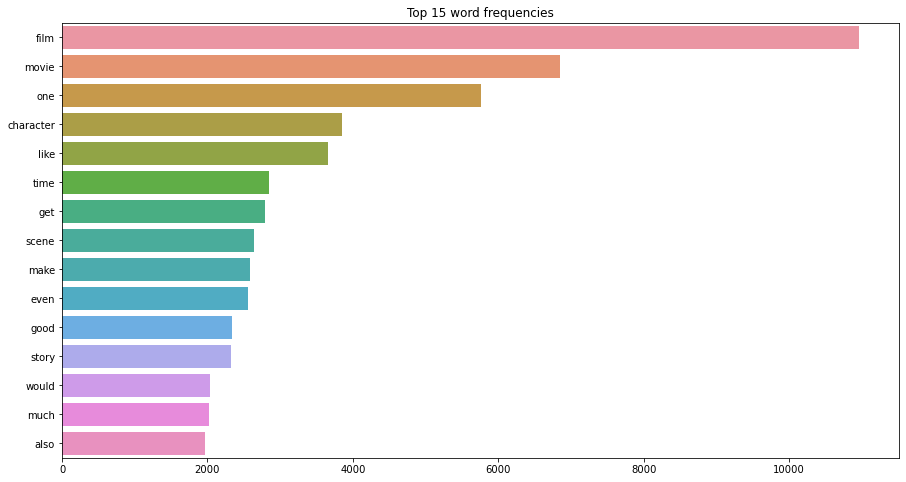

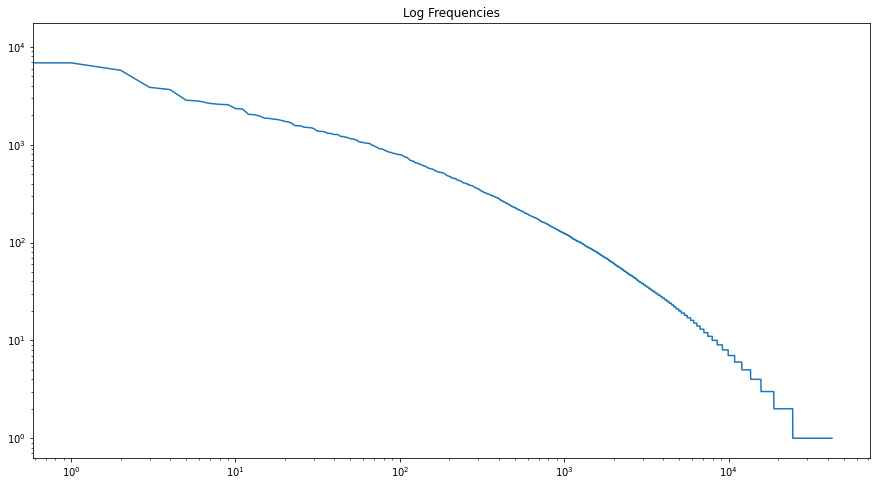

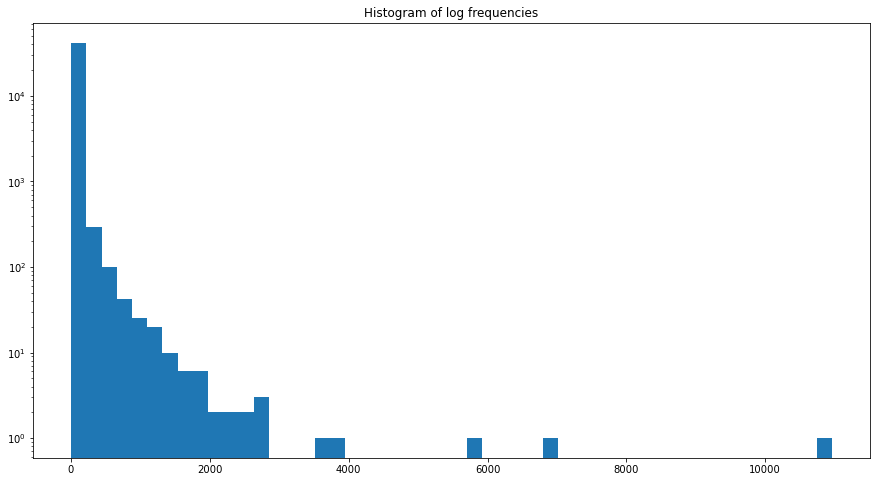

In [240]:
text_process.freq_plot('review_tokenized')


### 2.8 Remove frequent unimportant words

We have removed words like film and movie

In [241]:
text_process.remove_freq_unimportant_words('review_tokenized', n = 2)
text_process.df['review_tokenized'][review_num]

['youve',
 'got',
 'mail',
 'work',
 'alot',
 'better',
 'deserves',
 'order',
 'make',
 'success',
 'cast',
 'two',
 'extremely',
 'popular',
 'attractive',
 'star',
 'share',
 'screen',
 'two',
 'hour',
 'collect',
 'profit',
 'real',
 'acting',
 'involved',
 'original',
 'inventive',
 'bone',
 'body',
 'basically',
 'complete',
 'reshoot',
 'shop',
 'around',
 'corner',
 'adding',
 'modern',
 'twist',
 'essentially',
 'go',
 'defies',
 'concept',
 'good',
 'contemporary',
 'filmmaking',
 'overly',
 'sentimental',
 'time',
 'terribly',
 'mushy',
 'mention',
 'manipulative',
 'oh',
 'enjoyable',
 'manipulation',
 'must',
 'something',
 'casting',
 'manipulation',
 'make',
 'work',
 'well',
 'absolutely',
 'hated',
 'previous',
 'ryanhanks',
 'teaming',
 'sleepless',
 'seattle',
 'couldnt',
 'directing',
 'helmed',
 'woman',
 'havent',
 'quite',
 'yet',
 'figured',
 'liked',
 'much',
 'youve',
 'got',
 'mail',
 'really',
 'important',
 'like',
 'something',
 'much',
 'even',
 'question

### 3. NLTK Sentiment Analyser

#### 3.1 Approach 1

In [261]:
text_process.nltk_sentiment_analysis('raw_review')
text_process.df

,review,label,raw_review,nltk_sentiment
0,films adapted from comic books have had plenty...,pos,films adapted from comic books have had plenty...,neg
1,every now and then a movie comes along from a ...,pos,every now and then a movie comes along from a ...,neg
2,you've got mail works alot better than it dese...,pos,you've got mail works alot better than it dese...,pos
3,""" jaws "" is a rare film that grabs your atten...",pos,""" jaws "" is a rare film that grabs your atten...",neg
4,moviemaking is a lot like being the general ma...,pos,moviemaking is a lot like being the general ma...,neg
...,...,...,...,...
1995,"if anything , "" stigmata "" should be taken as ...",neg,"if anything , "" stigmata "" should be taken as ...",neg
1996,"john boorman's "" zardoz "" is a goofy cinematic...",neg,"john boorman's "" zardoz "" is a goofy cinematic...",neg
1997,the kids in the hall are an acquired taste . \...,neg,the kids in the hall are an acquired taste . \...,neg
1998,there was a time when john carpenter was a gre...,neg,there was a time when john carpenter was a gre...,neg


In [262]:
text_process.nltk_sentiment_evaluation()

Accuracy for NLTK Sentiment Analyzer::  0.6795
Classification report :: 
               precision    recall  f1-score   support

         neg       0.65      0.78      0.71      1000
         pos       0.72      0.58      0.64      1000

    accuracy                           0.68      2000
   macro avg       0.69      0.68      0.68      2000
weighted avg       0.69      0.68      0.68      2000



#### Approach 2

#### Naive Bayes

In [ ]:
text_process.nltk_sentiment_analysis_bow_2(NaiveBayesClassifier.train)

In [ ]:
from nltk.classify import DecisionTreeClassifier

## Modeling

### Creating Bag-Of-Words using Count Vectorizer

In [186]:
cnt_vec, X_bow, y = text_process.create_bow('review_tokenized', max_features = 25000)

cnt_vec, X_bow.shape

(CountVectorizer(max_features=25000), (2000, 25000))

### Train Test Split

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X_bow.toarray(), y, test_size=0.3, random_state=100)
print ("Number of positive reviews in training set: " , y_train.sum())
print ("Number of positive reviews in test set: ",y_test.sum())

print ("Ratio of positive reviews in training set: " , round(y_train.sum()/len(y_train),2))
print ("Ratio of positive reviews in testing data set: ", round(y_test.sum()/len(y_test),2))

Number of positive reviews in training set:  704
Number of positive reviews in test set:  296
Ratio of positive reviews in training set:  0.5
Ratio of positive reviews in testing data set:  0.49


## Modeling and Performance Metrics

### Decision Tree Classifier

Decision tree is a non linear tree based classfier, which does not perform that well on this dataset, with a test accuracy of 0.63 and roc-auc score of 0.63

Model ROC-AUC score for training sample: 1.000
Model ROC-AUC score for test sample: 0.629
Train Accuracy ::  1.0
Test Accuracy ::  0.6283333333333333
Classification report :: 
               precision    recall  f1-score   support

           0       0.64      0.61      0.62       304
           1       0.62      0.65      0.63       296

    accuracy                           0.63       600
   macro avg       0.63      0.63      0.63       600
weighted avg       0.63      0.63      0.63       600



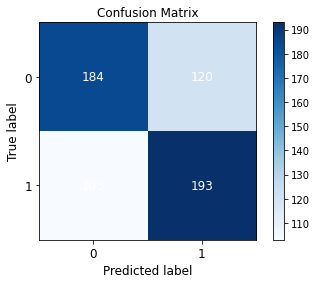

In [188]:
dt = text_process.train_evaluate_model(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)

### Logistic Regression

Logistic regression performs the best with test accuracy of 0.84 and roc-auc score of 0.91

Model ROC-AUC score for training sample: 1.000
Model ROC-AUC score for test sample: 0.912
Train Accuracy ::  1.0
Test Accuracy ::  0.8416666666666667
Classification report :: 
               precision    recall  f1-score   support

           0       0.84      0.85      0.84       304
           1       0.84      0.83      0.84       296

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.84      0.84      0.84       600



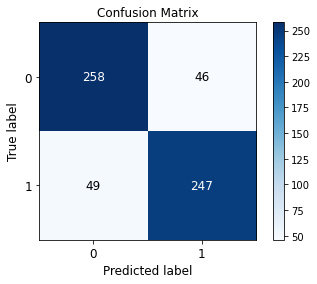

In [48]:
lr = text_process.train_evaluate_model(LogisticRegression(), X_train, X_test, y_train, y_test)

### Naive Bayes

Naive Bayes also performs well, with test accuracy 0.83 and roc-auc score 0.89

Model ROC-AUC score for training sample: 0.998
Model ROC-AUC score for test sample: 0.899
Train Accuracy ::  0.9807142857142858
Test Accuracy ::  0.8366666666666667
Classification report :: 
               precision    recall  f1-score   support

           0       0.82      0.87      0.84       304
           1       0.86      0.80      0.83       296

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.84      0.84      0.84       600



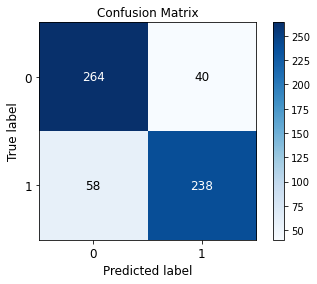

In [49]:
nb = text_process.train_evaluate_model(MultinomialNB(), X_train, X_test, y_train, y_test)

### Random Forest

Random forest is a tree based ensemble modeling algorithm and it performs well, with test accuracy 0.81 and roc-auc score of 0.89

Model ROC-AUC score for training sample: 1.000
Model ROC-AUC score for test sample: 0.904
Train Accuracy ::  1.0
Test Accuracy ::  0.8216666666666667
Classification report :: 
               precision    recall  f1-score   support

           0       0.81      0.84      0.83       304
           1       0.83      0.80      0.82       296

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82       600



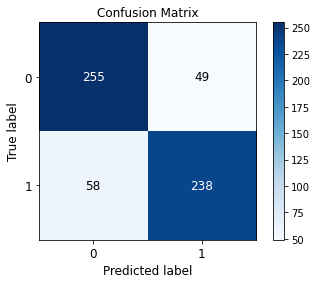

In [50]:
rf = text_process.train_evaluate_model(RandomForestClassifier(), X_train, X_test, y_train, y_test)

### Gradient Boosting

Gradient boosting is a boosting ensembling algorithm, and it performs well with test accuracy 0.82 and roc-auc score 0.89, but is computationally expensive.

Model ROC-AUC score for training sample: 0.998
Model ROC-AUC score for test sample: 0.894
Train Accuracy ::  0.9785714285714285
Test Accuracy ::  0.805
Classification report :: 
               precision    recall  f1-score   support

           0       0.82      0.79      0.80       304
           1       0.79      0.82      0.81       296

    accuracy                           0.81       600
   macro avg       0.81      0.81      0.80       600
weighted avg       0.81      0.81      0.80       600



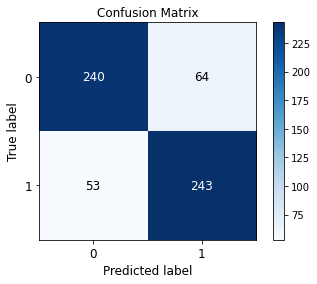

In [23]:
gb = text_process.train_evaluate_model(GradientBoostingClassifier(), X_train, X_test, y_train, y_test)

### Hyperparameter Tuning
Note: Takes time to run

#### Logistic Regression

In [53]:
param_grid = {
    #"penalty":["l2", "elasticnet", None],
    "C":[0.001, 0.01, 0.1]
 }

opt_lr = text_process.hyperparameter_tuning(LogisticRegression(), param_grid, X_train, y_train, cv = 5)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
0.8264285714285714
{'C': 0.01}


#### Random Forest

In [ ]:
param_grid = {
 #'bootstrap': [True, False],
 'max_depth': [10,  50, None],
 #'max_features': ['auto', 'sqrt'],
 #'min_samples_leaf': [1, 2, 4],
 #'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 600, 1000]
}

opt_rf = text_process.hyperparameter_tuning(RandomForestClassifier(), param_grid, X_train, y_train, cv = 5)

### Model comparison best metrics

Model |            Test Accuracy  |   Test ROC-AUC Score 
-------------------|---------|----------
Decision Tree | 0.63 |0.63
Logistic Regression | 0.841 | 0.91
Naive Bayes |0.836 |0.89
Random Forest| 0.816| 0.89
Gradient Boosting| 0.821| 0.89

From the experiments, we see Logistic Regression has the best performance in terms of both accuracy and roc-auc score in all models, closely followed by Naive Bayes and Gradient Boosting and Random Forest. Decision tree tends to overfit, with high training accuracy and low test accuracy.